In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append(str(Path(".").resolve().parent))

In [4]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [5]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)

_StoreAction(option_strings=[], dest='natural_language_stimulus_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [6]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"))
else:
    args = p.parse_args()

---

In [7]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)

In [8]:
print("Num words:", len(stim.word_lengths))
print("Num candidates:", stim.p_word.shape[-1])

Num words: 2187
Num candidates: 1000


Text(0.5, 0, 'Ground-truth word probability')

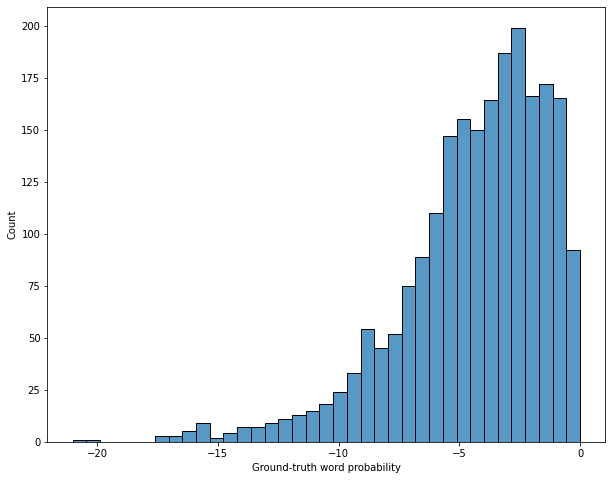

In [9]:
gt_word_probs = stim.p_word[:, 0].numpy()

plt.subplots(figsize=(10, 8))
sns.histplot(gt_word_probs)
plt.xlabel("Ground-truth word probability")

In [10]:
candidate_lengths = (stim.candidate_phonemes != stim.pad_phoneme_id).sum(dim=2)
gt_lengths, candidate_lengths = candidate_lengths[:, 0], candidate_lengths[:, 1:]
candidate_mean_lengths = candidate_lengths.float().mean(dim=1)

<AxesSubplot:title={'center':'Candidate lengths (in phonemes)'}, ylabel='Count'>

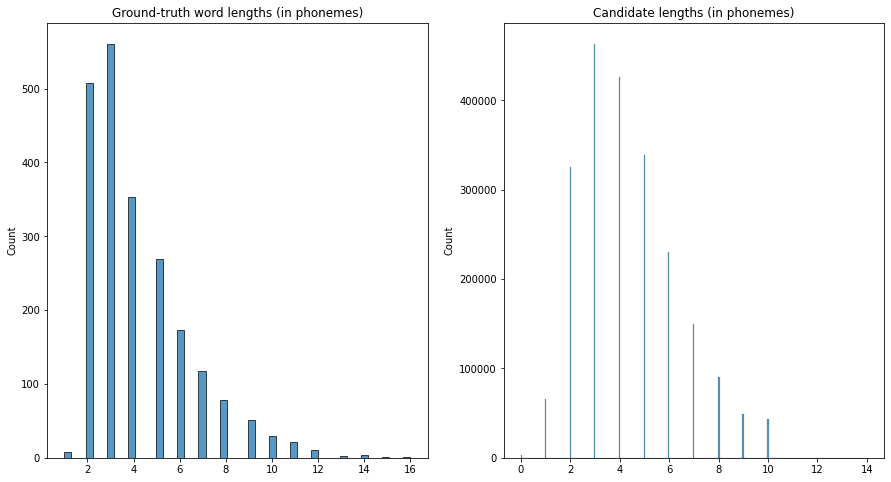

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Ground-truth word lengths (in phonemes)")
ax2.set_title("Candidate lengths (in phonemes)")

sns.histplot(gt_lengths.numpy(), ax=ax1)
sns.histplot(candidate_lengths.flatten().numpy(), ax=ax2)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Fraction of candidates which are incremental cohort competitors, by phoneme position'}, xlabel='phoneme', ylabel='is_competitor'>

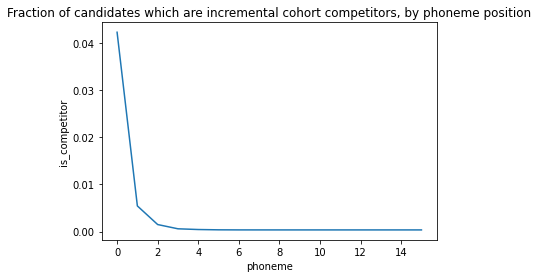

In [12]:
# For each candidate, is it a cohort competitor with ground truth?
# Compute this in batches because it's expensive
max_num_phonemes = stim.candidate_phonemes.shape[2]
is_cohort_competitor = []
batch_size = 256
for i in trange(0, stim.candidate_phonemes.shape[0] + batch_size, batch_size):
    batch = stim.candidate_phonemes[i:i+batch_size]
    if len(batch) == 0:
        break
        
    is_cohort_competitor.append(
        (batch[:, 1:] == batch[:, :1]).cumsum(dim=2) == torch.arange(1, max_num_phonemes + 1))
is_cohort_competitor = torch.concat(is_cohort_competitor, dim=0)

plt.title("Fraction of candidates which are incremental cohort competitors, by phoneme position")
sns.lineplot(data=pd.DataFrame(is_cohort_competitor.reshape(-1, max_num_phonemes).numpy()).melt(var_name="phoneme", value_name="is_competitor"),
             x="phoneme", y="is_competitor", ci=None)

In [13]:
print("Percentage of words which have a candidate which is a cohort competitor for at least one phoneme:",
      is_cohort_competitor.any(dim=2).any(dim=1).float().mean().item() * 100)

Percentage of words which have a candidate which is a cohort competitor for at least one phoneme: 81.84728026390076


In [14]:
print("Percentage of words which have a candidate which is a cohort competitor at phoneme X:\n",
      pd.DataFrame(is_cohort_competitor.any(dim=1).float().mean(dim=0).numpy() * 100))

Percentage of words which have a candidate which is a cohort competitor at phoneme X:
             0
0   81.847282
1   74.897118
2   51.851852
3   33.836304
4   27.023319
5   23.914038
6   23.045267
7   22.725195
8   22.633745
9   22.633745
10  22.633745
11  22.633745
12  22.633745
13  22.633745
14  22.633745
15  22.633745


Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort: 0.007672466803342104


<AxesSubplot:>

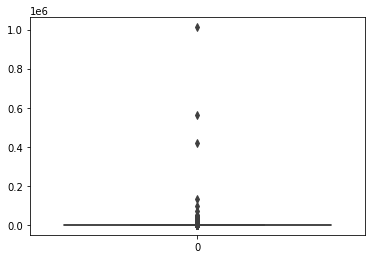

In [15]:
candidate_competitors = is_cohort_competitor.any(dim=2)
gt_probability_ratios = stim.p_word[:, 1:].exp() / stim.p_word[:, :1].exp()

print("Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort:", 
      gt_probability_ratios[candidate_competitors].median().item())
sns.boxplot(data=gt_probability_ratios[candidate_competitors].numpy())

In [18]:
def visualize_candidates(word_idx):
    all_cands = stim.get_candidate_strs(word_idx)
    competitor_mask = [np.inf] + is_cohort_competitor[word_idx].sum(dim=1).tolist()
    return sorted([(count, cand) for cand, count in zip(all_cands, competitor_mask) if count > 0], reverse=True)

In [19]:
visualize_candidates(0)

> /net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/datasets/processor/base.py(98)get_candidate_strs()
     97         import ipdb; ipdb.set_trace()
---> 98         rets = ["".join(self.phonemes[phon_idx] for phon_idx in word
     99                         if phon_idx != self.pad_phoneme_id)



ipdb>  
ipdb>  c


[(inf, 'klɛinə'),
 (16, 'klɛinə'),
 (4, 'klɛinstə'),
 (2, 'klɑsikə'),
 (2, 'klɑp'),
 (2, 'klɑntə'),
 (2, 'klœrə'),
 (2, 'klœr'),
 (2, 'klm'),
 (2, 'kl'),
 (2, 'kl'),
 (1, 'kʏnst'),
 (1, 'kɪndərə'),
 (1, 'kɛrst'),
 (1, 'kɛrn'),
 (1, 'kɛrk'),
 (1, 'kɛrk'),
 (1, 'kɛnəs'),
 (1, 'kɛik'),
 (1, 'kɔstə'),
 (1, 'kɔrtə'),
 (1, 'kɔrtə'),
 (1, 'kɔrt'),
 (1, 'kɔp'),
 (1, 'kɔn'),
 (1, 'kɔmt'),
 (1, 'kɔmst'),
 (1, 'kɔm'),
 (1, 'kɑnt'),
 (1, 'kɑns'),
 (1, 'kɑn'),
 (1, 'kœzə'),
 (1, 'kœkə'),
 (1, 'kwɛsti'),
 (1, 'kwɑm'),
 (1, 'kwalitɛit'),
 (1, 'kurs'),
 (1, 'krɑntə'),
 (1, 'krɑnt'),
 (1, 'kron'),
 (1, 'krht'),
 (1, 'konɪŋɪn'),
 (1, 'konɪŋɪn'),
 (1, 'konɪŋkləkə'),
 (1, 'konɪŋ'),
 (1, 'konɪŋ'),
 (1, 'koməndə'),
 (1, 'knvb'),
 (1, 'kndr'),
 (1, 'kel'),
 (1, 'kart'),
 (1, 'kamər'),
 (1, 'kamər'),
 (1, 'ka'),
 (1, 'ka'),
 (1, 'k')]

In [20]:
stim.candidate_phonemes[1, 0]

tensor([23,  3, 11,  3, 15, 11, 33, 12, 11, 30, 29, 14, 38, 38, 38, 38])

In [30]:
visualize_candidates(10)

[(inf, 'ɑls'),
 (16, 'ɑls'),
 (16, 'ɑls'),
 (3, 'ɑlsɔf'),
 (2, 'ɑləs'),
 (2, 'ɑləmal'),
 (2, 'ɑlə'),
 (2, 'ɑltɛit'),
 (2, 'ɑlen'),
 (2, 'ɑl'),
 (2, 'ɑl'),
 (1, 'ɑt'),
 (1, 'ɑs'),
 (1, 'ɑrmə'),
 (1, 'ɑrm'),
 (1, 'ɑr'),
 (1, 'ɑndərs'),
 (1, 'ɑfxəslotə'),
 (1, 'ɑfxənomə'),
 (1, 'ɑfxəbelt'),
 (1, 'ɑf'),
 (1, 'ɑf')]